In [2]:
!pip install cmake opencv-python
!conda install -y dlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.9/28.9 MB 65.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 48.8 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [cmake]32m1/2 [cmake]
Channels:
 - conda-forge
Platform: linux-64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 25.5.1
    latest version: 25.11.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - dlib


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2026.1.4   |       hbd8a1cb_0         143 KB  conda-forge
    certifi-2026.1.4           |     pyhd8ed1ab_0         147 KB  conda-forge
    dlib-20.0.0                |cpu_py312hb8e531a_0         3.3 MB  conda-forge
    openssl-3.

In [3]:
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
import os

print("OpenCV:", cv2.__version__)
print("dlib:", dlib.__version__)

OpenCV: 4.13.0
dlib: 20.0.0


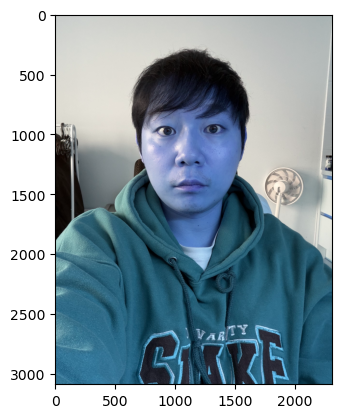

In [194]:
home_dir = os.getenv('HOME')
my_image_path = os.path.join(home_dir, 'work/camera_sticker/images/image1.jpg') 
img_bgr = cv2.imread(my_image_path)    
img_show = img_bgr.copy()      
plt.imshow(img_bgr) 
plt.show() # 이미지를 출력해준다. (실제 출력)

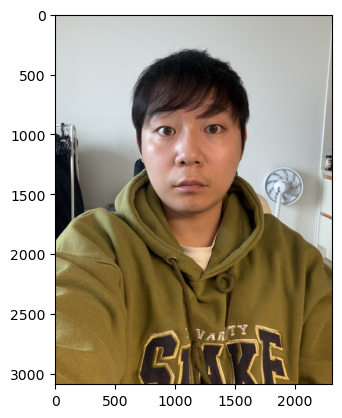

In [195]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb) 
plt.show() 

In [196]:
detector_hog = dlib.get_frontal_face_detector() 
print("🌫🛸")

🌫🛸


In [197]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   
print("🌫🛸")

🌫🛸


원래 dlib_rects: rectangles[[(617, 724) (1575, 1682)], [(1987, 1430) (2076, 1519)]]
선택된 dlib_rects: [rectangle(617,724,1575,1682)]


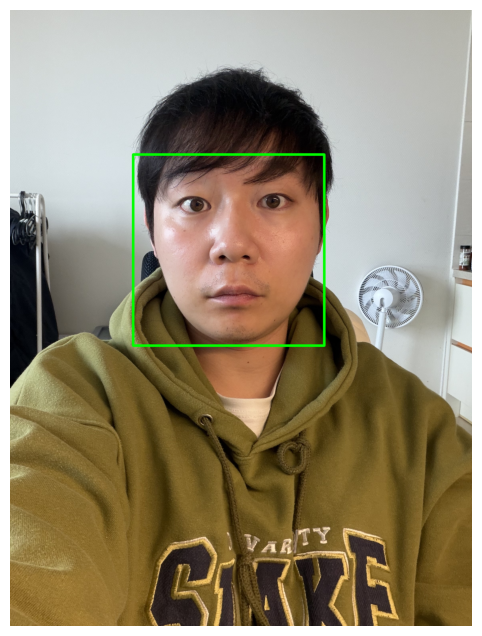

In [198]:
# 그냥 인식을 시켰을때 배경에 있는 선풍기를 얼굴로 인식하는 문제가 발생하여 아래 코드와 같이 변형하여 문제를 해결함
# 선풍기에 인식된 사각형보다 얼굴 사각형이 더 크므로 더 큰 사각형으로 변경하였다.
print("원래 dlib_rects:", dlib_rects)


dlib_rect = max(dlib_rects, key=lambda r: r.width() * r.height())
dlib_rects = [dlib_rect]
print("선택된 dlib_rects:", dlib_rects)


img_show = img_bgr.copy()


for rect in dlib_rects:
    l, t, r, b = rect.left(), rect.top(), rect.right(), rect.bottom()
    cv2.rectangle(img_show, (l, t), (r, b), (0, 255, 0), 12)

# 5) 출력
plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


In [199]:
!cd ~/work/camera_sticker && bzip2 -d ./models/shape_predictor_68_face_landmarks.dat.bz2

bzip2: Output file ./models/shape_predictor_68_face_landmarks.dat already exists.


In [200]:
model_path = os.path.join(home_dir, 'work/camera_sticker/models/shape_predictor_68_face_landmarks.dat')

landmark_predictor = dlib.shape_predictor(model_path)
print("🌫🛸")

🌫🛸


In [201]:
list_landmarks = []

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
     
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        
    list_landmarks.append(list_points)
 

print(len(list_landmarks[0]))
   

68


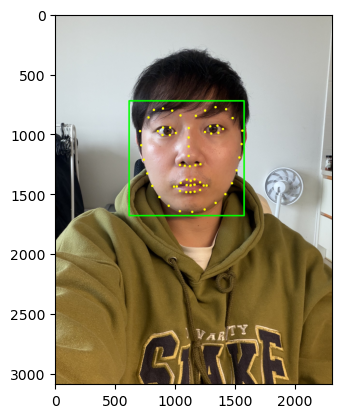

In [202]:

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 10, (0, 255, 255), -1)
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

plt.imshow(img_show_rgb)

plt.show()


In [203]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks): 
    print (landmark[33]) 
    x = landmark[33][0] 
    y = landmark[33][1] 
    w = h = dlib_rect.width() 
    print (f'(x,y) : ({x},{y})')
    print (f'(w,h) : ({w},{h})')

(1123, 1270)
(x,y) : (1123,1270)
(w,h) : (959,959)


In [204]:
sticker_path = os.path.join(home_dir, 'work/camera_sticker/images/cat.png') 
img_sticker = cv2.imread(sticker_path) 
img_sticker = cv2.resize(img_sticker, (w,h)) 
print (img_sticker.shape) 

(959, 959, 3)


In [205]:
refined_x = x - w // 2
refined_y = y - h // 2
print (f'(x,y) : ({refined_x},{refined_y})') # 음수 발생 : 이미지 범위를 벗어남

(x,y) : (644,791)


In [206]:
# 1️⃣ 스티커 영역 추출 (원문 유지)
sticker_area = img_show[
    refined_y:refined_y + img_sticker.shape[0],
    refined_x:refined_x + img_sticker.shape[1]
]

# 2️⃣ 스티커를 grayscale로
sticker_gray = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2GRAY)

# 3️⃣ 흰 배경 마스크 (중요: < 240)
mask = sticker_gray < 240   # 수염/코 부분만 True

# 4️⃣ 마스크를 3채널로 확장
mask_3ch = np.repeat(mask[:, :, None], 3, axis=2)

# 5️⃣ 합성 (핵심 수정)
result = np.where(mask_3ch, img_sticker, sticker_area).astype(np.uint8)

# 6️⃣ 결과 다시 원본 이미지에 덮기
img_show[
    refined_y:refined_y + img_sticker.shape[0],
    refined_x:refined_x + img_sticker.shape[1]
] = result

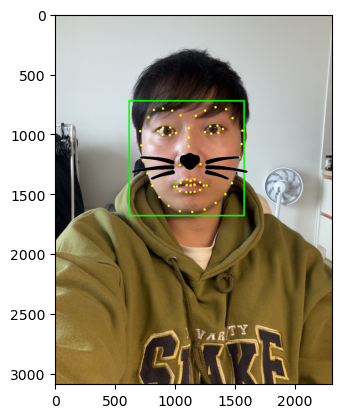

In [207]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

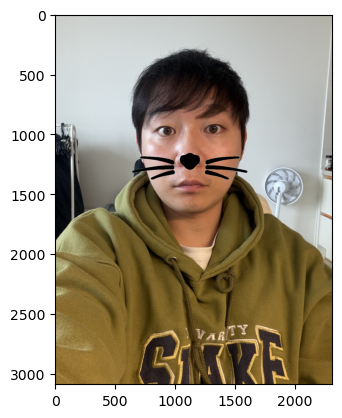

In [208]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
sticker_gray = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2GRAY)
mask_bg = sticker_gray > 240
img_bgr[
    refined_y:refined_y + img_sticker.shape[0],
    refined_x:refined_x + img_sticker.shape[1]
] = np.where(mask_bg[..., None], sticker_area, img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)) # rgb만 적용해놓은 원본 이미지에 왕관 이미지를 덮어 씌운 이미지가 나오게 된다.
plt.show()

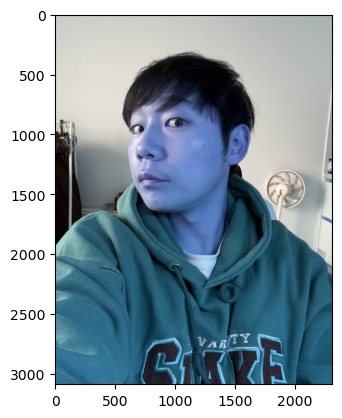

In [210]:
home_dir = os.getenv('HOME')
my_image_path = os.path.join(home_dir, 'work/camera_sticker/images/image2.jpg') 
img_bgr = cv2.imread(my_image_path)    
img_show = img_bgr.copy()      
plt.imshow(img_bgr) 
plt.show() # 이미지를 출력해준다. (실제 출력)

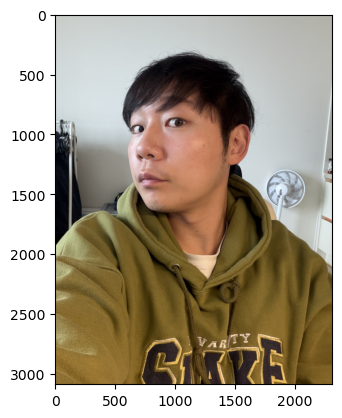

In [211]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb) 
plt.show() 

In [212]:
detector_hog = dlib.get_frontal_face_detector() 
print("🌫🛸")

🌫🛸


In [213]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   
print("🌫🛸")

🌫🛸


원래 dlib_rects: rectangles[[(404, 617) (1362, 1576)], [(1997, 1460) (2086, 1549)]]
선택된 dlib_rects: [rectangle(404,617,1362,1576)]


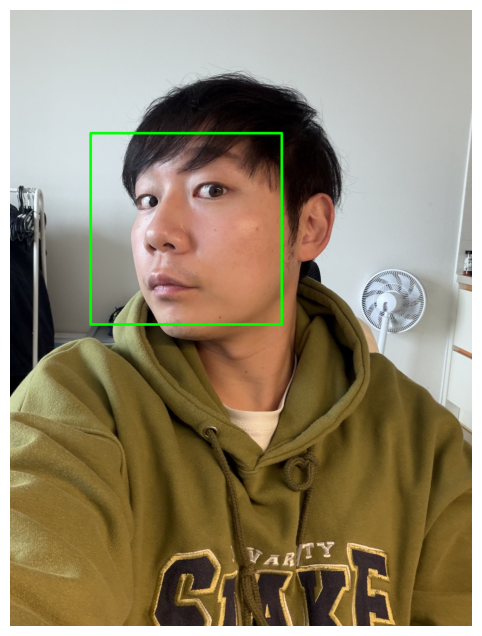

In [214]:

print("원래 dlib_rects:", dlib_rects)


dlib_rect = max(dlib_rects, key=lambda r: r.width() * r.height())
dlib_rects = [dlib_rect]
print("선택된 dlib_rects:", dlib_rects)


img_show = img_bgr.copy()


for rect in dlib_rects:
    l, t, r, b = rect.left(), rect.top(), rect.right(), rect.bottom()
    cv2.rectangle(img_show, (l, t), (r, b), (0, 255, 0), 12)

# 5) 출력
plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


In [215]:
list_landmarks = []

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
     
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        
    list_landmarks.append(list_points)
 

print(len(list_landmarks[0]))

68


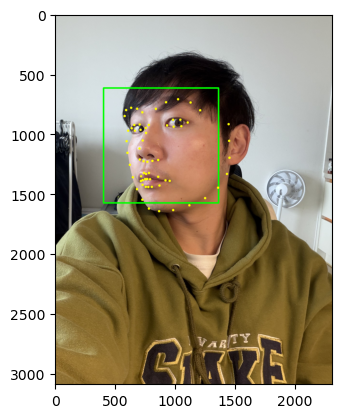

In [216]:

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 10, (0, 255, 255), -1)
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

plt.imshow(img_show_rgb)

plt.show()


In [217]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks): 
    print (landmark[33]) 
    x = landmark[33][0] 
    y = landmark[33][1] 
    w = h = dlib_rect.width() 
    print (f'(x,y) : ({x},{y})')
    print (f'(w,h) : ({w},{h})')

(769, 1233)
(x,y) : (769,1233)
(w,h) : (959,959)


In [218]:
sticker_path = os.path.join(home_dir, 'work/camera_sticker/images/cat.png') 
img_sticker = cv2.imread(sticker_path) 
img_sticker = cv2.resize(img_sticker, (w,h)) 
print (img_sticker.shape) 

(959, 959, 3)


In [219]:
refined_x = x - w // 2
refined_y = y - h // 2
print (f'(x,y) : ({refined_x},{refined_y})') # 음수 발생 : 이미지 범위를 벗어남

(x,y) : (290,754)


In [220]:
# 1️⃣ 스티커 영역 추출 (원문 유지)
sticker_area = img_show[
    refined_y:refined_y + img_sticker.shape[0],
    refined_x:refined_x + img_sticker.shape[1]
]

# 2️⃣ 스티커를 grayscale로
sticker_gray = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2GRAY)

# 3️⃣ 흰 배경 마스크 (중요: < 240)
mask = sticker_gray < 240   # 수염/코 부분만 True

# 4️⃣ 마스크를 3채널로 확장
mask_3ch = np.repeat(mask[:, :, None], 3, axis=2)

# 5️⃣ 합성 (핵심 수정)
result = np.where(mask_3ch, img_sticker, sticker_area).astype(np.uint8)

# 6️⃣ 결과 다시 원본 이미지에 덮기
img_show[
    refined_y:refined_y + img_sticker.shape[0],
    refined_x:refined_x + img_sticker.shape[1]
] = result

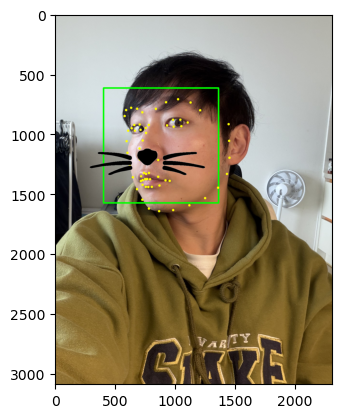

In [221]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

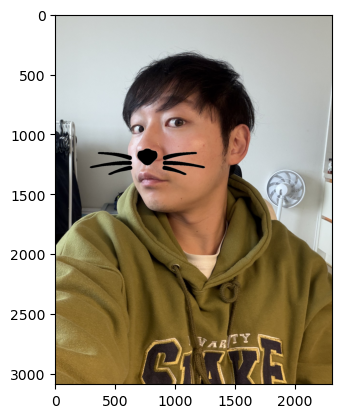

In [223]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
sticker_gray = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2GRAY)
mask_bg = sticker_gray > 240
img_bgr[
    refined_y:refined_y + img_sticker.shape[0],
    refined_x:refined_x + img_sticker.shape[1]
] = np.where(mask_bg[..., None], sticker_area, img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)) # rgb만 적용해놓은 원본 이미지에 왕관 이미지를 덮어 씌운 이미지가 나오게 된다.
plt.show()

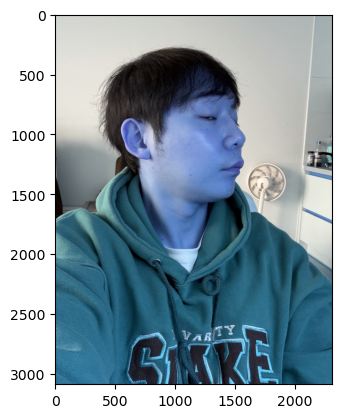

In [5]:
home_dir = os.getenv('HOME')
my_image_path = os.path.join(home_dir, 'work/camera_sticker/images/image3.jpg') 
img_bgr = cv2.imread(my_image_path)    
img_show = img_bgr.copy()      
plt.imshow(img_bgr) 
plt.show() # 이미지를 출력해준다. (실제 출력)

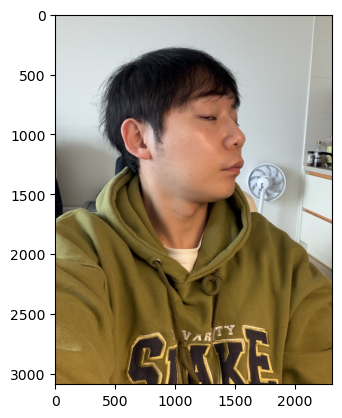

In [6]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb) 
plt.show() 

In [7]:
detector_hog = dlib.get_frontal_face_detector() 
print("🌫🛸")

🌫🛸


In [8]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   
print("🌫🛸")


🌫🛸


In [9]:
print("원래 dlib_rects:", dlib_rects)

dlib_rect = max(dlib_rects, key=lambda r: r.width() * r.height())
dlib_rects = [dlib_rect]
print("선택된 dlib_rects:", dlib_rects)


img_show = img_bgr.copy()


for rect in dlib_rects:
    l, t, r, b = rect.left(), rect.top(), rect.right(), rect.bottom()
    cv2.rectangle(img_show, (l, t), (r, b), (0, 255, 0), 12)

원래 dlib_rects: rectangles[]


ValueError: max() iterable argument is empty

In [10]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 2)   
print("🌫🛸")


🌫🛸


원래 dlib_rects: [rectangle(993,625,1821,1453)]
선택된 dlib_rects: [rectangle(993,625,1821,1453)]


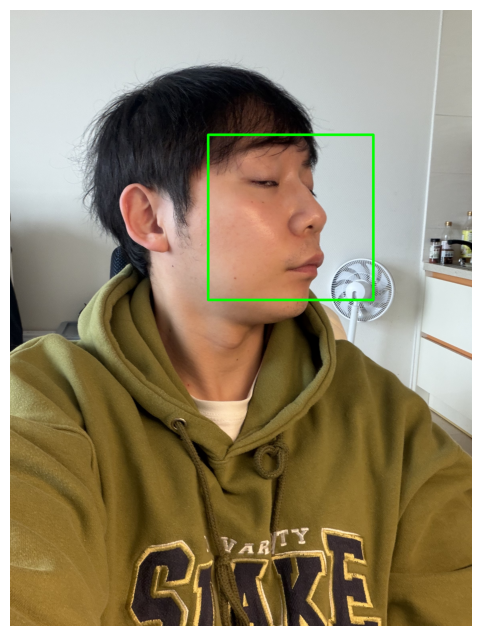

In [12]:
print("원래 dlib_rects:", dlib_rects)

dlib_rect = max(dlib_rects, key=lambda r: r.width() * r.height())
dlib_rects = [dlib_rect]
print("선택된 dlib_rects:", dlib_rects)


img_show = img_bgr.copy()


for rect in dlib_rects:
    l, t, r, b = rect.left(), rect.top(), rect.right(), rect.bottom()
    cv2.rectangle(img_show, (l, t), (r, b), (0, 255, 0), 12)

# 5) 출력
plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


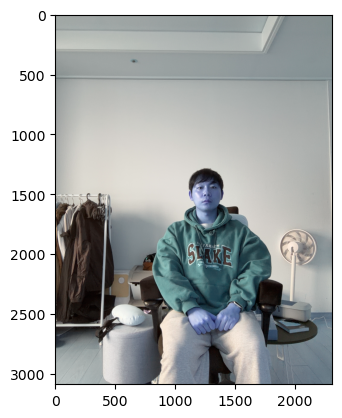

In [13]:
home_dir = os.getenv('HOME')
my_image_path = os.path.join(home_dir, 'work/camera_sticker/images/image4.jpg') 
img_bgr = cv2.imread(my_image_path)    
img_show = img_bgr.copy()      
plt.imshow(img_bgr) 
plt.show() # 이미지를 출력해준다. (실제 출력)

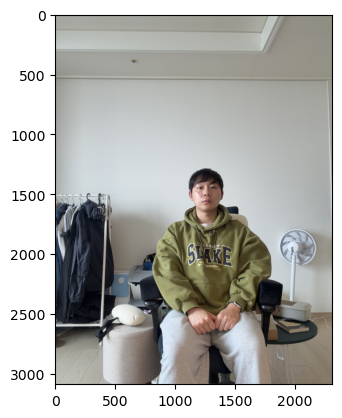

In [14]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb) 
plt.show() 

In [15]:
detector_hog = dlib.get_frontal_face_detector() 
print("🌫🛸")

🌫🛸


In [16]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   
print("🌫🛸")

🌫🛸


원래 dlib_rects: rectangles[[(1122, 1390) (1389, 1657)]]
선택된 dlib_rects: [rectangle(1122,1390,1389,1657)]


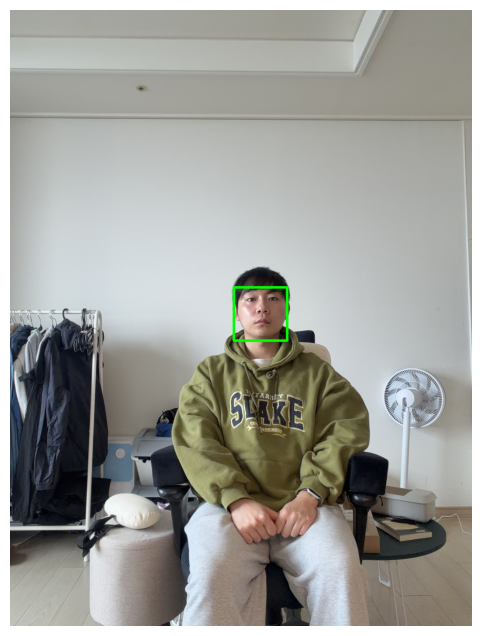

In [17]:
print("원래 dlib_rects:", dlib_rects)

dlib_rect = max(dlib_rects, key=lambda r: r.width() * r.height())
dlib_rects = [dlib_rect]
print("선택된 dlib_rects:", dlib_rects)


img_show = img_bgr.copy()


for rect in dlib_rects:
    l, t, r, b = rect.left(), rect.top(), rect.right(), rect.bottom()
    cv2.rectangle(img_show, (l, t), (r, b), (0, 255, 0), 12)

# 5) 출력
plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

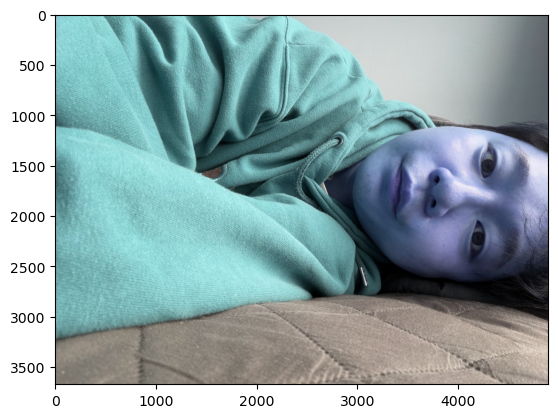

In [18]:
home_dir = os.getenv('HOME')
my_image_path = os.path.join(home_dir, 'work/camera_sticker/images/image5.jpg') 
img_bgr = cv2.imread(my_image_path)    
img_show = img_bgr.copy()      
plt.imshow(img_bgr) 
plt.show() # 이미지를 출력해준다. (실제 출력)

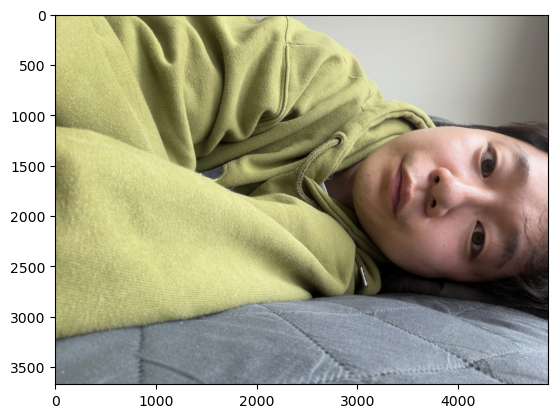

In [19]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb) 
plt.show() 

In [20]:
detector_hog = dlib.get_frontal_face_detector() 
print("🌫🛸")


🌫🛸


In [21]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   
print("🌫🛸")

🌫🛸


In [22]:
print("원래 dlib_rects:", dlib_rects)

dlib_rect = max(dlib_rects, key=lambda r: r.width() * r.height())
dlib_rects = [dlib_rect]
print("선택된 dlib_rects:", dlib_rects)


img_show = img_bgr.copy()


for rect in dlib_rects:
    l, t, r, b = rect.left(), rect.top(), rect.right(), rect.bottom()
    cv2.rectangle(img_show, (l, t), (r, b), (0, 255, 0), 12)

# 5) 출력
plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

원래 dlib_rects: rectangles[]


ValueError: max() iterable argument is empty

In [23]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 2)   
print("🌫🛸")

🌫🛸


In [24]:
print("원래 dlib_rects:", dlib_rects)

dlib_rect = max(dlib_rects, key=lambda r: r.width() * r.height())
dlib_rects = [dlib_rect]
print("선택된 dlib_rects:", dlib_rects)


img_show = img_bgr.copy()


for rect in dlib_rects:
    l, t, r, b = rect.left(), rect.top(), rect.right(), rect.bottom()
    cv2.rectangle(img_show, (l, t), (r, b), (0, 255, 0), 12)

# 5) 출력
plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

원래 dlib_rects: rectangles[]


ValueError: max() iterable argument is empty

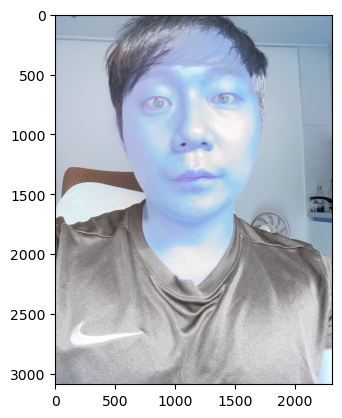

In [25]:
home_dir = os.getenv('HOME')
my_image_path = os.path.join(home_dir, 'work/camera_sticker/images/image6.jpg') 
img_bgr = cv2.imread(my_image_path)    
img_show = img_bgr.copy()      
plt.imshow(img_bgr) 
plt.show() # 이미지를 출력해준다. (실제 출력)

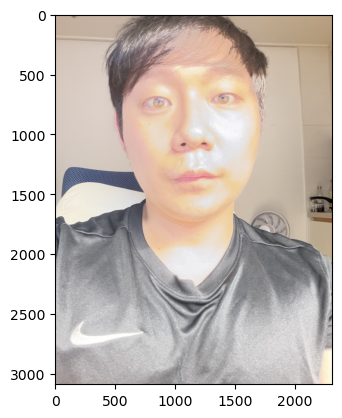

In [26]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb) 
plt.show() 

In [27]:
detector_hog = dlib.get_frontal_face_detector() 
print("🌫🛸")

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   
print("🌫🛸")


🌫🛸
🌫🛸


원래 dlib_rects: rectangles[[(613, 486) (1763, 1636)]]
선택된 dlib_rects: [rectangle(613,486,1763,1636)]


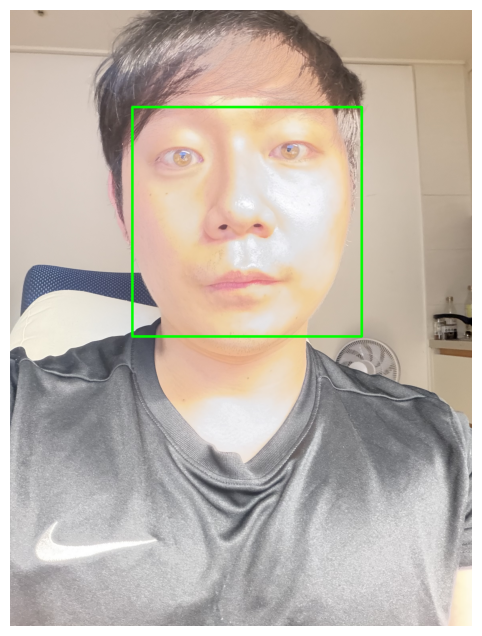

In [28]:
print("원래 dlib_rects:", dlib_rects)

dlib_rect = max(dlib_rects, key=lambda r: r.width() * r.height())
dlib_rects = [dlib_rect]
print("선택된 dlib_rects:", dlib_rects)


img_show = img_bgr.copy()


for rect in dlib_rects:
    l, t, r, b = rect.left(), rect.top(), rect.right(), rect.bottom()
    cv2.rectangle(img_show, (l, t), (r, b), (0, 255, 0), 12)

# 5) 출력
plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

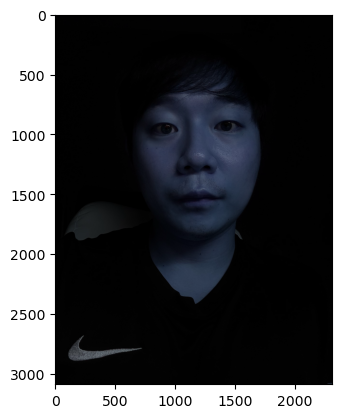

In [30]:
home_dir = os.getenv('HOME')
my_image_path = os.path.join(home_dir, 'work/camera_sticker/images/image7.jpg') 
img_bgr = cv2.imread(my_image_path)    
img_show = img_bgr.copy()      
plt.imshow(img_bgr) 
plt.show() # 이미지를 출력해준다. (실제 출력)

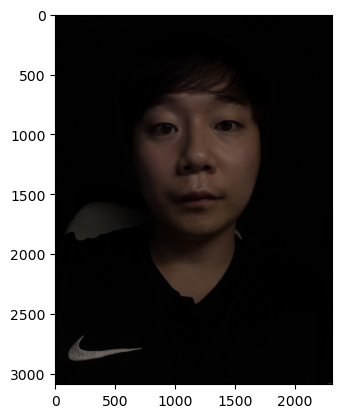

In [31]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb) 
plt.show() 

In [33]:
detector_hog = dlib.get_frontal_face_detector() 
print("🌫🛸")



img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   
print("🌫🛸")


🌫🛸
🌫🛸


원래 dlib_rects: rectangles[[(613, 613) (1763, 1764)]]
선택된 dlib_rects: [rectangle(613,613,1763,1764)]


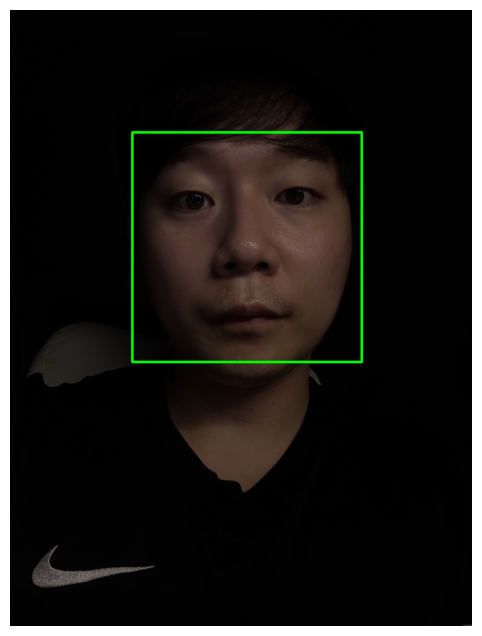

In [34]:
print("원래 dlib_rects:", dlib_rects)

dlib_rect = max(dlib_rects, key=lambda r: r.width() * r.height())
dlib_rects = [dlib_rect]
print("선택된 dlib_rects:", dlib_rects)


img_show = img_bgr.copy()


for rect in dlib_rects:
    l, t, r, b = rect.left(), rect.top(), rect.right(), rect.bottom()
    cv2.rectangle(img_show, (l, t), (r, b), (0, 255, 0), 12)

# 5) 출력
plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

## 1. 실험 목적
본 실험의 목적은 dlib의 HOG 기반 얼굴 검출기를 이용하여  
다양한 촬영 조건(거리, 각도, 자세)에서 얼굴 인식이 어떻게 동작하는지 확인하고,  
검출 파라미터 변경이 인식 성능에 어떤 영향을 미치는지 분석하는 것이다.

---

## 2. 실험 환경
- 라이브러리
  - OpenCV
  - dlib (HOG 기반 face detector)
- 얼굴 검출 방식
  - `dlib.get_frontal_face_detector()`
- 랜드마크 모델
  - `shape_predictor_68_face_landmarks.dat`

---

## 3. 실험 방법

### 3.1 촬영 조건별 실험
다음과 같은 조건에서 이미지를 촬영하여 얼굴 인식을 시도하였다.

#### 1.가까이서 촬영한 이미지
#### 2.멀리서 촬영한 이미지
#### 3.얼굴을 측면(옆모습)으로 촬영한 이미지
#### 4.얼굴을 옆으로 누운 상태(회전된 상태)에서 촬영한 이미지
#### 5.사진을 엄청 어둡게 또는 밝게

실험에 사용한 이미지 예시는 아래와 같다.

<img src="./image2.jpg" width="300">


---

## 4. 실험 결과

### 4.1 기본 설정에서의 결과
-----------
#### 1.가까이서 촬영한 이미지

- 사진을 일반적으로 가까이서 촬영하게 되었을 때 얼굴을 인식 잘함.
- 허나 문제점이 하나 생겼던게, 뒤에 선풍기를 인식하는 문제가 생김
<img src="./image8.PNG" width="300">
- 그래서 코드를 아래와 같이 조금 수정하여 줬음
  
```python
dlib_rect = max(dlib_rects, key=lambda r: r.width() * r.height())
dlib_rects = [dlib_rect]
```

-----------
#### 2.멀리서 촬영한 이미지
- 사진을 멀리서 촬영하게 되었을 때 예상외로 얼굴을 인식함.
- 하지만 멀리의 기준이 어느 정도 한계가 있어 더 멀리 촬영해볼 필요성이 있음.
<img src="./image9.PNG" width="300">



-----------
#### 3.얼굴을 측면(옆모습)으로 촬영한 이미지
- 얼굴 측면으로 찍었을 때 인식하는 경우도 있고 못하는 경우도 있음.
- 그리하여 아래와 같이 detector_hog의 두 번째 인자를 `2`로 설정했을 때 얼굴을 인식함
<img src="./image11.PNG" width="300">
```python
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 2)
```
-----------
#### 4.얼굴을 옆으로 누운 상태(회전된 상태)에서 촬영한 이미지
- 얼굴을 옆으로 누운상태에서 찍었을 때 인식을 못함.
- 이전과 같이 detctor_hog의 두 번째 인자를 `2`로 설정해도 인식 못함
<img src="./image10.PNG" width="300">

-----------
#### 5.사진을 엄청 어둡게 또는 밝게
- 예상외로 인식을 잘함.
- 허나 밝기를 더 어둡게 하거나 밝게하면 어떻게 될 지 모르겠어 추가실험을 요함.
<img src="./image12.PNG" width="300">
<img src="./image13.PNG" width="300">